In [1]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT

Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
# psrname = 'J1643-1224'
psrname = 'J1012+5307'
maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/*-[JB]*.feather'))]
Tspan_pta = ds.getspan(psrs)
print(Tspan_pta / 365.25 / 86400)
names = [psr.name for psr in psrs]
idx = names.index(psrname)
psr = psrs[idx]
Tspan_psr = ds.getspan([psr])
n_rn_freqs = 30

16.029777268872294


In [3]:
# for injection purposes
psrl = ds.PulsarLikelihood([psr.residuals,
                        ds.makenoise_measurement(psr, psr.noisedict),
                        ds.makegp_ecorr(psr, psr.noisedict),
                        ds.makegp_timing(psr, variance=1e-19),
                        ds.makegp_fourier(psr, ds.freespectrum, n_rn_freqs, T=Tspan_psr, name='red_noise')])

In [4]:
psrl.logL.params

['J1012+5307_red_noise_log10_rho(30)']

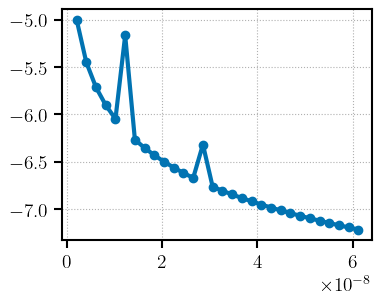

30


In [5]:
freqs = np.arange(1, n_rn_freqs+1) / Tspan_psr
logf = np.log10(freqs)
injection = -5 + -1.5 * (logf - logf[0])
injection[5] += 1
injection[13] += 0.4
plt.plot(freqs, injection, '-o')
plt.show()

print(freqs.size)

In [6]:
residuals = psrl.sample(jax.random.PRNGKey(34), {'J1012+5307_red_noise_log10_rho(30)': injection})
print(residuals[1])

[-3.23278724e-05 -1.47062945e-05 -1.85465272e-05 ... -1.57272941e-05
 -1.27101554e-05 -1.89138151e-05]


In [7]:
psr.residuals = np.array(residuals[1])

<ErrorbarContainer object of 3 artists>

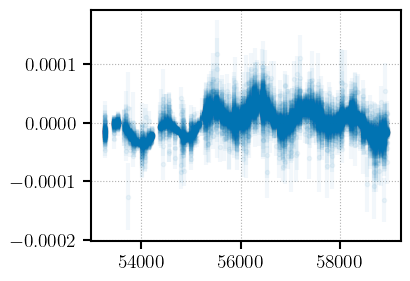

In [8]:
plt.errorbar(psr.toas / 86400, psr.residuals, yerr=psr.toaerrs, fmt='.', alpha=0.05)

In [12]:
model, psrl = lncass_models.create_rn_single_psr_model(psr, n_rn_freqs)

In [15]:
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10),
    num_warmup=10000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [16]:
with numpyro.validation_enabled():
    lncass_outliers_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT})


sample: 100%|██████████| 11000/11000 [05:32<00:00, 33.07it/s, 255 steps of size 1.56e-02. acc. prob=0.80] 


In [17]:
samples = lncass_outliers_sampler.get_samples()

In [18]:
lncass_outliers_sampler.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta_xi_o[0]     -0.02      0.96     -0.06     -1.52      1.52    706.48      1.00
       beta_xi_o[1]     -0.04      0.90     -0.03     -1.64      1.32    857.58      1.00
       beta_xi_o[2]      0.01      0.87      0.01     -1.36      1.56    679.24      1.00
       beta_xi_o[3]      0.07      0.93      0.06     -1.45      1.68    765.77      1.00
       beta_xi_o[4]      1.51      0.70      1.43      0.38      2.65    135.67      1.00
       beta_xi_o[5]     -0.63      0.92     -0.70     -2.01      1.05    509.99      1.00
       beta_xi_o[6]     -0.53      0.99     -0.57     -1.93      1.24    481.62      1.01
       beta_xi_o[7]      0.22      0.88      0.27     -1.30      1.56    543.44      1.00
       beta_xi_o[8]     -0.04      0.95     -0.03     -1.53      1.60    476.71      1.00
       beta_xi_o[9]      0.00      0.94      0.01     -1.57      1.57    656.83      1.00
      bet

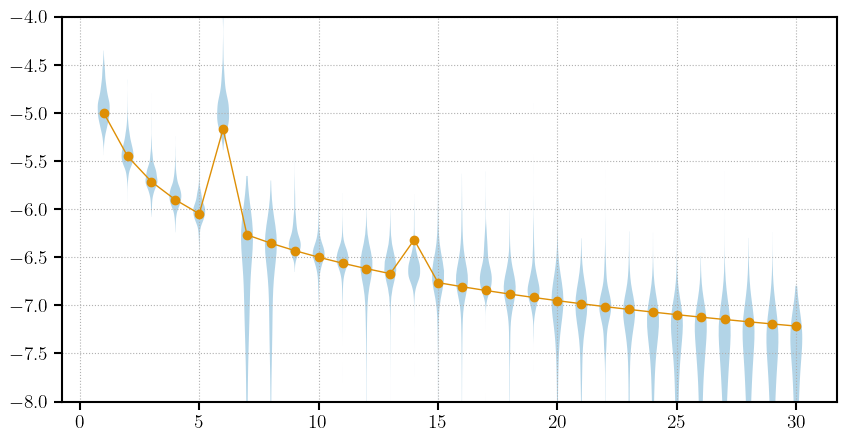

In [19]:
plt.figure(figsize=(10, 5))
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False)
plt.plot(np.arange(1, n_rn_freqs+1), injection, '-o', lw=1)
plt.ylim(-8, -4)
plt.show()

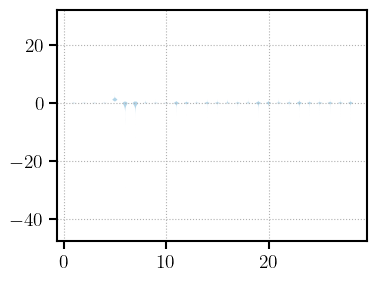

In [20]:
plt.violinplot(samples['beta_o'], showextrema=False)
plt.show()

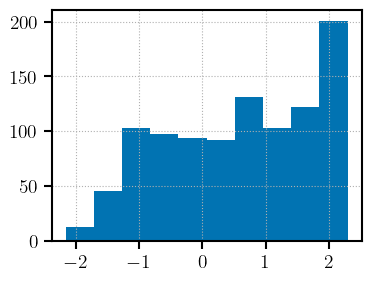

In [21]:
plt.hist(np.log(samples['sigma_lambda_rn']))
plt.show()

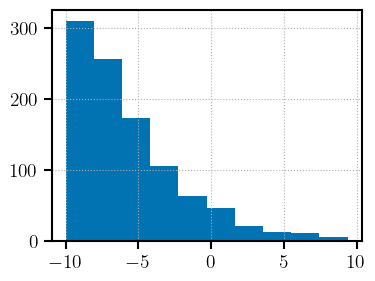

In [22]:
plt.hist((samples['mu_lambda_rn']))
plt.show()

In [23]:
samples['lambdas_rn'].shape

(1000, 28)

In [24]:
from scipy.special import expit
def plot_lncass_priors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    axes = axes.ravel()
    # histogram sigma_lambda_rn
    axes[0].hist(samples[f'sigma_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[0].set_title(f'$\\sigma_{{\\lambda_{{ {tag} }}}}$')
    # histogram mu_lambda_rn
    axes[1].hist(samples[f'mu_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[1].set_title(f'$\\mu_{{\\lambda_{{ {tag} }}}}$')
    # get prior on b's
    lam_prior_vals = []
    b_prior_vals = []
    for ii in range(1000):
        idx = np.random.randint(0, samples[f'tau_{tag}'].shape[0])
        lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_{tag}'][idx] + samples[f'mu_lambda_{tag}'][idx])
        lam_prior_vals.extend(lam_prior.tolist())
        bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_{tag}'][idx]
        b_prior_vals.extend(bvals)
    lam_prior_vals = np.array(lam_prior_vals)

    b_prior_vals = np.array(b_prior_vals)
    axes[2].hist(lam_prior_vals.flatten(), bins=50, density=True, histtype='step', color='b', alpha=0.5)
    axes[2].set_title(f'$\\lambda_{{ {tag} }}$ Prior')
    axes[2].set_yscale("log")
    # axes[2].set_xscale("log")
    axes[3].hist(b_prior_vals.flatten(), bins=200, density=True, histtype='step', color='b', alpha=0.5)
    # axes[3].set_yscale("log")
    axes[3].set_ylim(0, 0.01)
    axes[3].set_title(f'$b_{{ {tag} }}$ Prior')
    plt.tight_layout()
    plt.show()

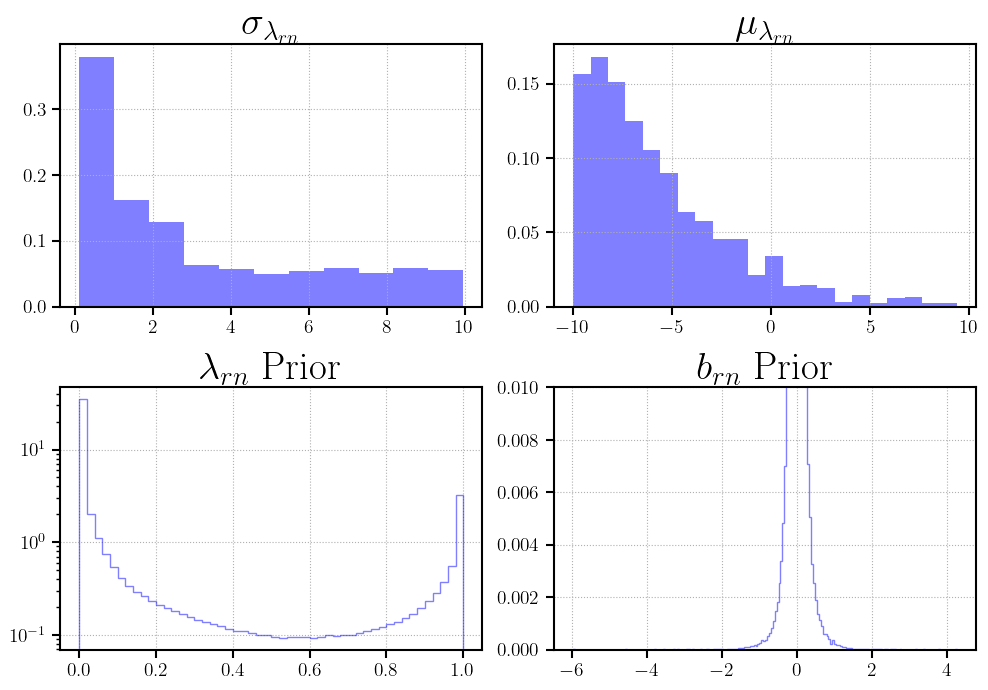

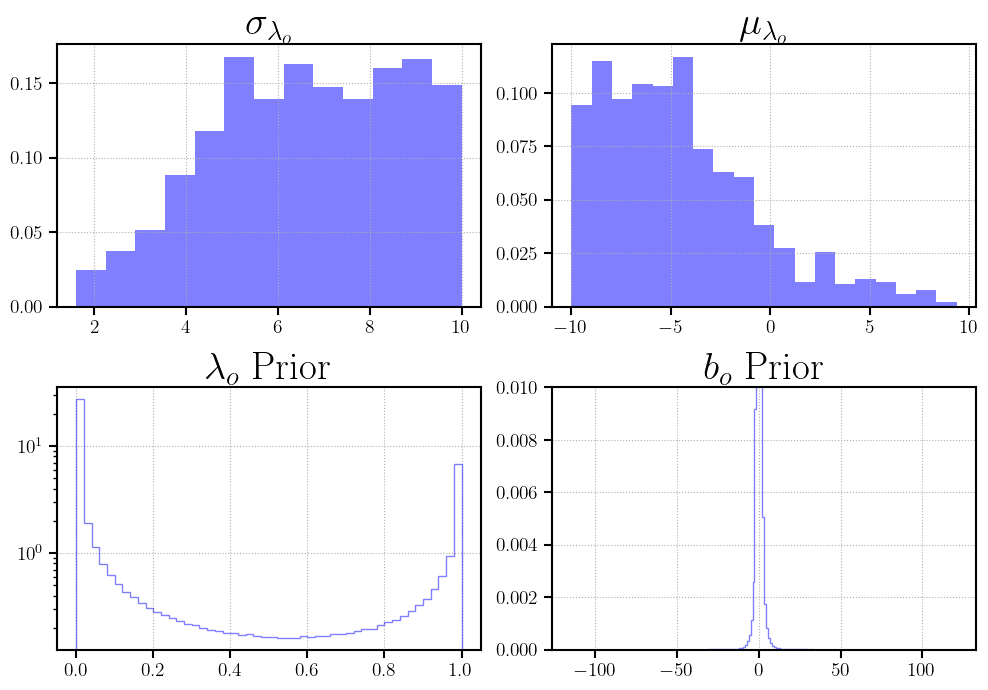

In [25]:
plot_lncass_priors(samples)
plot_lncass_priors(samples, tag='o')


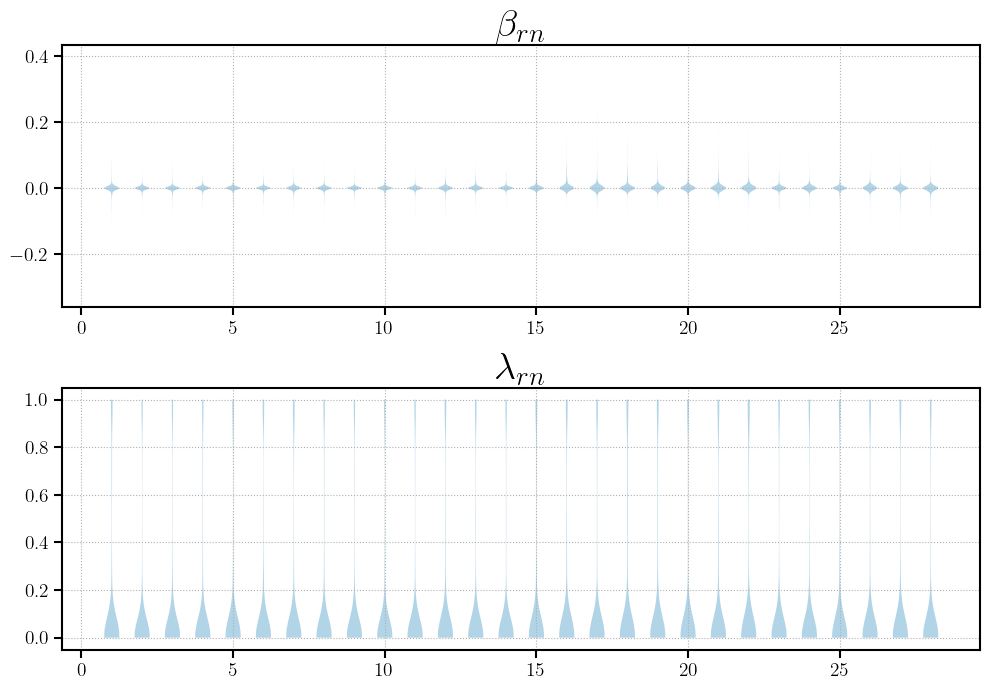

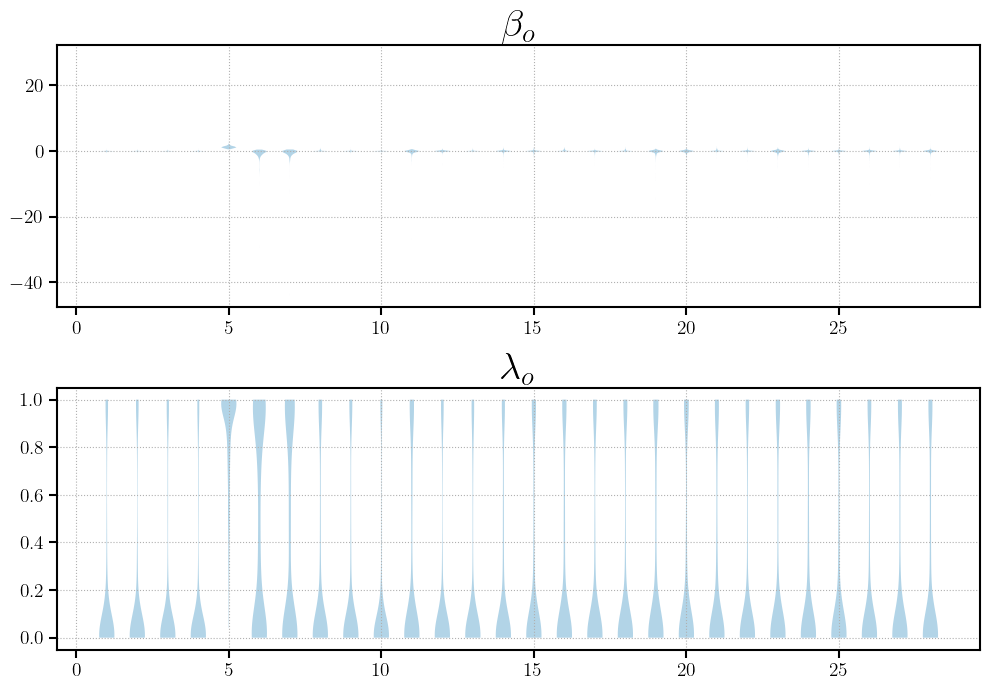

In [26]:

import matplotlib.gridspec as gridspec

def plot_lncass_posteriors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    axes = axes.ravel()
    axes[0].violinplot(samples[f'beta_{tag}'], showextrema=False)
    axes[0].set_title(f'$\\beta_{{ {tag} }}$')
    
    axes[1].violinplot(samples[f'lambdas_{tag}'], showextrema=False)
    axes[1].set_title(f'$\\lambda_{{ {tag} }}$')
    
    plt.tight_layout()
    plt.show()

plot_lncass_posteriors(samples)
plot_lncass_posteriors(samples, tag='o')

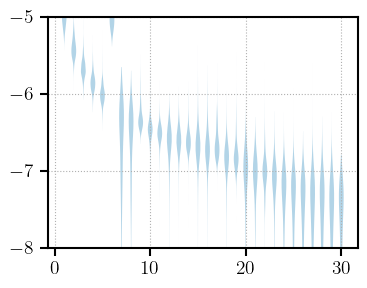

In [27]:
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False)
plt.ylim(-8, -5)
plt.show()

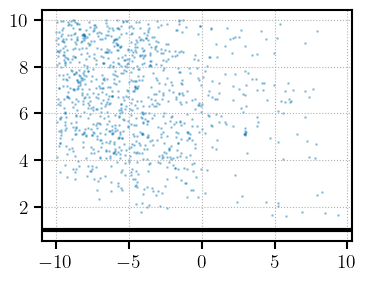

In [28]:
plt.scatter(samples['mu_lambda_o'], samples['sigma_lambda_o'], s=1, alpha=0.3)
ax =    plt.gca()
ax.axhline(1, c='k')

In [29]:
pl_model, pl_psrl = lncass_models.create_single_psr_powerlaw_model(psr, n_rn_freqs)
pl_sampler = infer.MCMC(
    infer.NUTS(pl_model, max_tree_depth=10),
    num_warmup=10000,
    num_samples=10000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [30]:
with numpyro.validation_enabled():
    pl_sampler.run(jax.random.PRNGKey(13))

sample: 100%|██████████| 20000/20000 [00:21<00:00, 945.71it/s, 3 steps of size 4.32e-01. acc. prob=0.93]  


In [31]:
fspec_model, fs_psrl = lncass_models.create_single_psr_freespec_model(psr, n_rn_freqs)
fspec_sampler = infer.MCMC(
    infer.NUTS(fspec_model, max_tree_depth=10),
    num_warmup=10000,
    num_samples=10000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [32]:
with numpyro.validation_enabled():
    fspec_sampler.run(jax.random.PRNGKey(13))

sample: 100%|██████████| 20000/20000 [02:11<00:00, 152.55it/s, 31 steps of size 8.24e-02. acc. prob=0.90] 


In [33]:
fspec_samples = fspec_sampler.get_samples()
pl_samples = pl_sampler.get_samples()

In [34]:
pl_samples.keys()

dict_keys(['log10_A', 'log10_gamma'])

In [35]:
freqs = np.arange(1, 31) / ds.getspan([psr])
fyr = 1 / 365.25 / 86400
pl_rhos = np.array([np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2  for idx in range(1000)])

In [36]:
pl_rhos.shape

(1000, 30)

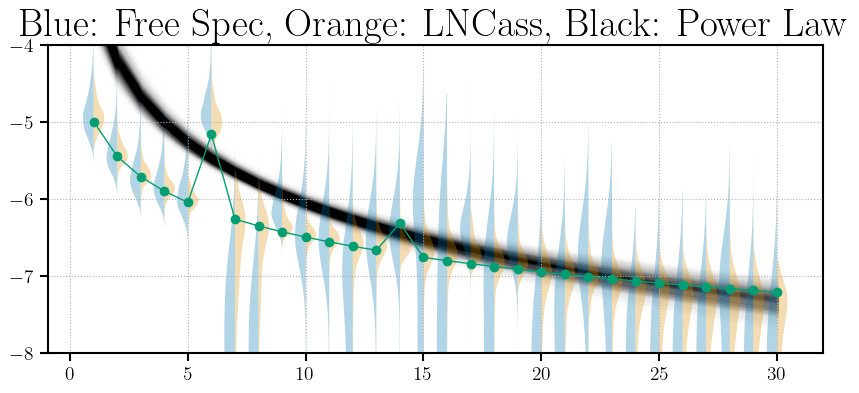

In [37]:
plt.figure(figsize=(10, 4))
plt.title("Blue: Free Spec, Orange: LNCass, Black: Power Law")
plt.violinplot(fspec_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
freqs = np.arange(1, 31) / ds.getspan([psr])
plt.plot(np.arange(1, n_rn_freqs+1), injection, '-o', lw=1)

plt.ylim(-8, -4)

for ii in range(1000):
    idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
    tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
    plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)

# Direct deviation from power law

In [38]:
spline_model, spl_psrl = lncass_models.create_rn_single_psr_spline_model(psr, n_rn_freqs, 60)
spline_sampler = infer.MCMC(
    infer.NUTS(spline_model, max_tree_depth=10),
    num_warmup=3000,
    num_samples=3000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [39]:
with numpyro.validation_enabled():
    spline_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT})

sample: 100%|██████████| 6000/6000 [01:19<00:00, 75.77it/s, 63 steps of size 5.32e-02. acc. prob=0.71]  


In [40]:
spline_samples = spline_sampler.get_samples()

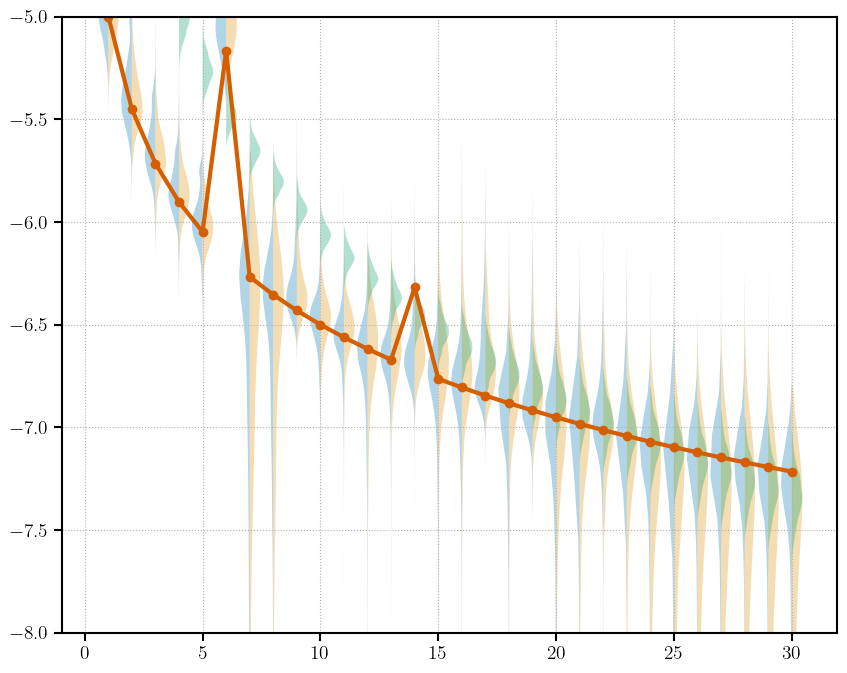

In [41]:
plt.figure(figsize=(10, 8))
plt.violinplot(spline_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
plt.violinplot(pl_rhos, showextrema=False, side="high", widths=0.9)
plt.ylim(-8, -5)
plt.plot(np.arange(1, n_rn_freqs+1),  injection, '-o')
# for ii in range(1000):
#     idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
#     tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
#     plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)
plt.show()

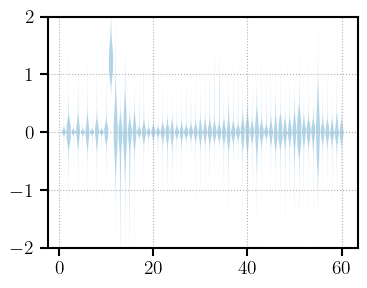

In [42]:
plt.violinplot(spline_samples['beta_rn'].squeeze(), showextrema=False, widths=0.9)
plt.ylim(-2, 2)
plt.show()

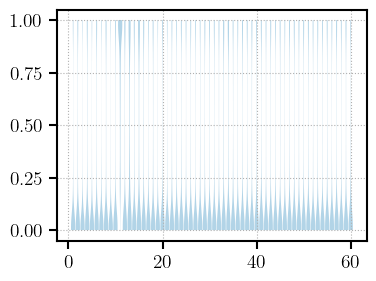

In [43]:
plt.violinplot(spline_samples['lambdas_rn'].squeeze(), showextrema=False, widths=0.9)
plt.show()